In [54]:
from sklearn.ensemble import *
from sklearn.linear_model import LinearRegression, BayesianRidge, HuberRegressor
from sklearn.kernel_ridge import KernelRidge
import sklearn.metrics
from sklearn.cross_validation import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_file_data(path):
    file = open(path, 'r')
    data = []
    for line in file:
        data.append(line.strip("\n").split())
    return data

def load_embedding(path, skipFirst = False):
    file = open(path, 'r')
    ids = []
    data = []
    for line in file:
        if skipFirst:
            skipFirst = False
            continue
        embedding = line.strip("\n").split()
        data.append(embedding)
    return np.array(data).astype('float64')

def convert_ids(ids, lookup_current, lookup_replace):
    """Replaces TransE IDs with our IDs because we use a different mapping.""" 
    # Replace
    new_ids = []
    for i in ids:
        new_ids.append(lookup_replace[lookup_current[str(i)]])
    return new_ids

In [3]:
dataset = 'fb15k'

In [4]:
entity_mapping = load_file_data('../data/'+dataset+'/entity_mapping.txt')
rel_mapping = load_file_data('../data/'+dataset+'/relation_mapping.txt')
sme_mapping = load_file_data('../data/'+dataset+'/id2entity.sme.txt')

In [5]:
our_mapping = dict(entity_mapping + rel_mapping)
sme_mapping = dict(sme_mapping)

In [6]:
train = load_file_data('../data/'+dataset+'/train.txt')
test = load_file_data('../data/'+dataset+'/test.txt')
valid = load_file_data('../data/'+dataset+'/valid.txt')

triples = np.concatenate([train, test, valid])

embeddings = load_embedding('../data/'+dataset+'/embeddings.transe.txt')

In [7]:
new_ids = convert_ids(np.arange(0, len(embeddings)), sme_mapping, our_mapping)
new_ids = np.reshape(np.array(new_ids), (-1, 1))
ent_flag = np.concatenate([np.ones((len(entity_mapping), 1)), np.zeros((len(rel_mapping), 1))])

In [8]:
# Add our ids to the embeddings and a flag whether it is an entitiy or relation embedding
embeddings = np.concatenate([new_ids, ent_flag, embeddings], axis=1)

In [9]:
def get_embedding(embedding_frame, idx, entity = 1):
    return embedding_frame[embedding_frame[0] == idx][embedding_frame[1] == entity].values.tolist()[0][2:]

In [10]:
def x_y_split(data, embeddings):
    embedding_frame = pd.DataFrame(embeddings, dtype='float64')
    x_cols = embedding_frame.columns.values[2:]
    embedding_frame[0] = embedding_frame[0].astype('int64')
    
    data_frame = pd.DataFrame(data=data, columns=['subject', 'object', 'relation'], dtype=np.int32)
    counts = data_frame.groupby('subject').count()['relation']

    y = counts.sort_index()
    x = embedding_frame[embedding_frame[0].isin(data_frame['subject'].unique())].sort_values(by=0).reset_index(drop=True)[x_cols]
    
    print(embedding_frame.shape)
    print(embedding_frame[0].unique().shape)
    print(data_frame['subject'].unique().shape)
    
    return x, y

In [99]:
def x_y_split_with_rel(triples, embeddings, n_entities):

    entity_embeddings = pd.DataFrame(embeddings[:n_entities, 2:], index=embeddings[:n_entities, 0].astype(np.int32), dtype='float64')
    relation_embeddings = pd.DataFrame(embeddings[n_entities:, 2:], index=embeddings[n_entities:, 0].astype(np.int32), dtype='float64')
    
    data_frame = pd.DataFrame(data=triples, columns=['subject', 'object', 'relation'], dtype=np.int32)
    counts = data_frame.groupby(['subject', 'relation']).count().reset_index()
    
    joined = counts.join(entity_embeddings, on='subject').join(relation_embeddings, on='relation', rsuffix='_rel', lsuffix='_ent')
    
    return joined[joined.columns[3:]], joined[joined.columns[2]]

In [100]:
entities = np.array(entity_mapping)[:, 1].astype('int32')
relations = np.array(rel_mapping)[:, 1].astype('int32')

x, y = x_y_split(triples, embeddings[:len(entity_mapping)])
x_rel, y_rel = x_y_split_with_rel(triples, embeddings, len(entities))

(14951, 52)
(14951,)
(14866,)


In [101]:
x_rel.shape, y_rel.shape

((174097, 100), (174097,))

In [102]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
x_train_rel, x_test_rel, y_train_rel, y_test_rel = train_test_split(x_rel, y_rel, test_size=0.3, random_state=0)

In [96]:
def offset_percentage(expected, predicted):
    error = np.absolute(expected - predicted)/expected
    return np.array(error)

In [103]:
regressors = [
   # ('RandomForest', RandomForestRegressor(20, max_depth=2, random_state=0)),
    ('GradientBoost', GradientBoostingRegressor(learning_rate=0.05, max_depth=4, random_state=0)),
    ('LinearRegression', LinearRegression()),
    ('BayesianRidge', BayesianRidge()),
    ('HuberRegressor', HuberRegressor()),
    #('KernelRidge', KernelRidge(random_state=0))
]
predictions = {}
predictions_rel = {}

for name, regr in regressors:
    regr.fit(x_train, y_train)
    predictions[name] = regr.predict(x_test)
    regr.fit(x_train_rel, y_train_rel)
    predictions_rel[name] = regr.predict(x_test_rel)

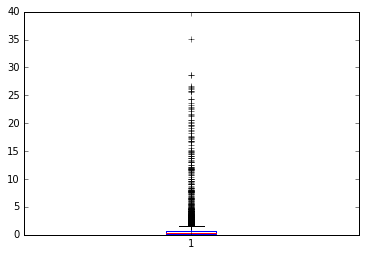

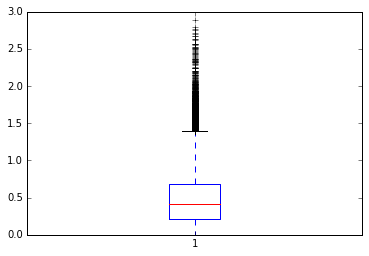

HuberRegressor APO without Relations 1.0197026283553028
HuberRegressor APO with Relations    0.4883047643616436


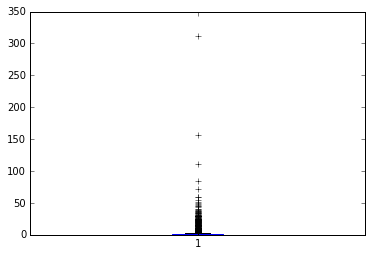

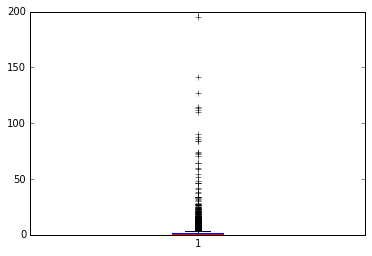

GradientBoost APO without Relations 1.9347760591430292
GradientBoost APO with Relations    1.2668063337403614


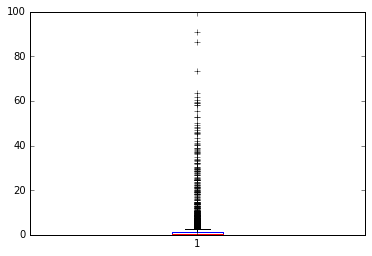

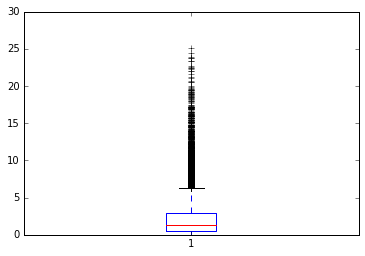

BayesianRidge APO without Relations 2.135202138670927
BayesianRidge APO with Relations    2.077634431906067


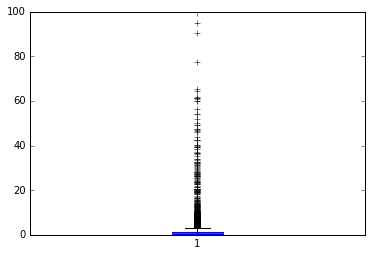

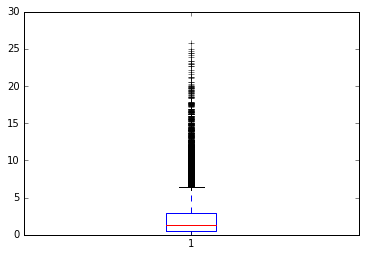

LinearRegression APO without Relations 2.1508473798530905
LinearRegression APO with Relations    2.1113805423946306


In [106]:
for name in predictions:
#     print(name, "MSE", sklearn.metrics.mean_squared_error(y_test, pred))
#     print(name, "MAE", sklearn.metrics.mean_absolute_error(y_test, pred))
#     print(name, "MedAE", sklearn.metrics.median_absolute_error(y_test, pred))
    op = offset_percentage(y_test, predictions[name])
    op_rel = offset_percentage(y_test_rel, predictions_rel[name])
    plt.boxplot(op)
    plt.show()
    plt.boxplot(op_rel)
    plt.show()
    print(name, "APO without Relations", np.mean(op))
    print(name, "APO with Relations   ", np.mean(op_rel))